# Marginalia Determination

Many of the volumes used in our corpus have marginalia on the pages. The purpose of the marginalia is to serve as a finding aid. It is not part of the laws and needed to be excluded from our corpus. In order to exclude the marginalia, we first had to determine the location of the marginalia on each page. The following notebook demonstrates the marginalia determination process. The purpose of this script is to prepare metadata describing the areas of the images that should not be OCR’d, so that the marginalia is not included in the corpus. Though this notebook displays a number of cropped and manipulated page images, in practice images like these are not stored. The crop metadata generated as output by this script is used during the OCR process to determine which areas of text should be fed to the OCR software. The background color metadata is used to produce clean margins for cropped images that will enable cleaner OCR output. 


A small subset of example images and their associated metadata have been included for demonstration purposes.

## Summary

`marginalia_determination` serves to identify which area of the original contains only the main body text. This process involves a number of sub-processes, including the trimming of blank margins, the removal of headers from most pages, and the separation of main body text from the marginalia. 

The general flow of `marginalia_determination` can be summarized as follows:
1. Determine important metadata for a batch of images. This metadata is a combination of mannually-generated information and metadata gathered from the Internet Archive. Metadata includes information like filepath, law type, page side, and whether or not a page begins a new section.
2. Import batch image files
3. Determine the best de-skew angle for straightening pages
4. Determine the image's median background color as well as a bounding box that has been cropped to text with headers removed where appropriate.
5. Determine the dividing "cut" line between main body text and marginalia
6. Derive main-body text boundary coordinates for the original page image
7. Record results from the above steps in a new crop metadata file

For details regarding each subprocess, see explanations below. Examples comparing results from each step will be provided at the end of this notebook.

## Imports/Setup

In [1]:
import sys
import os
import csv
import shutil
import time
import random

from collections import Counter
from PIL import Image, ImageChops, ImageStat
import numpy as np

from scipy.ndimage import interpolation as inter

In [2]:
#remove
import pandas as pd

First, we indicate our current directory so Python knows to check there for local modules (for this example we'll need 'cropfunctions.py'. The 'example_image.py' file contains scripts used only for demonstration purposes in this notebook. It is not part of the production code.)

In [3]:
sys.path.append(os.path.abspath("./"))
from cropfunctions import *

In [4]:
#remove
from example_image import *

## Metadata processing

The following code block extracts metadata for each page that is required to begin the marginalia determination process. The 'sample_metadata' file in this example represents a smallsubset of a larger file that holds metadata for all images. This metadata was compiled from the following sources:
* **filename**, **leafNum**, & **handSide** are derived from XML metadata files stored on the Internet Archive, the original source of our images
* **page** is determined manually. 
* **fileUrl** is derived from filename and leafNum
* **sectiontype** & **sectiontitle** were manually collected from the images themselves and documented elsewhere before being transferred to this metadata file


In the file, each row represents a single page leaf from the original scans. We extract the following information for each and compile a list of dictionaries, each with the following information:

* filename
* page side (right or left)
* folder name (one for each volume of laws, usually separated by year)
* type of laws contained on page (i.e. "constitution", "acts," "public laws extra," etc.)
* Automatically set "start section" to FALSE. This attribute is used to describe whether or not a given page is the beginning of a new section. This is important because such pages contain large headers and other unusual elements that must be accounted for

**Note:** The "filename" and "folder" fields are named according to the folder structure established for our set of images (i.e. "lawsresolutionso1891nort_0697.jp2" and "lawsresolutionso1891nort_jp2"). If used with a different set of images, the procedures in the following loop will need to be adjusted.

Once the list of metadata dictionaries (one for each row) has been assembled, the pages are sorted according to their filepath strings.

In [5]:
master = []

with open("sample_metadata.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        row_dict = dict()
        row_dict["filename"] = row["filename"] + ".jp2"
        row_dict["side"] = row["handSide"].lower()
        row_dict["folder"] = row["filename"].split("_")[0]+"_jp2"
        row_dict["type"] = row['sectiontype']
        row_dict["start_section"] = False
        master.append(row_dict)
        
    
master = sorted(master, key = lambda i: i['filename']) 

In [6]:
#Each "row" will look as follows:
print(master[0])

{'filename': 'lawsresolutionso1891nort_0697.jp2', 'side': 'right', 'folder': 'lawsresolutionso1891nort_jp2', 'type': 'public laws', 'start_section': False}


Once we have extracted the required metadata, we determine which pages mark the beginning of a new "type." This is important because section "start" pages often contain large headers with important metadata. The steps below remove all headers except those from "start_section" pages so that we can retain the information they contain. To do so we iterate through all pages in our 'master' list. If it is found that a given page "type" is different from the page immediately before it, the page in question is designated as a "start" page. This assumes that no sections of identical "types" will follow one another consecutively.

Our examples images are of two different "types."

In [7]:
for k in range(1,len(master)):
    if master[k]["type"] != master[k-1]["type"]:
        master[k]["start_section"] = True

In [8]:
#start section values for sample images
print([i["start_section"] for i in master])

[False, True, False]


## Marginalia determination process

### Gathering unedited image files

In order to better illustrate the functionality of this module, the following code blocks walk through the marginalia determination process for three examples images. In practice this code would exist as part of a loop to enable large batch processing. The 'meta' list below would normally house the metadata for an entire batch of image transformations. For this demonstration, it will hold a list of metadata for our three images.

In [9]:
meta = []

To begin, we open the image file associated with each row of metadata. Normally this happens for each image at the beginning of the aforementioned loop. 

**It is important to note** *that our original files from the Internet Archive were formatted as JP2000s. The files are converted to JPGs in this example in order to increase accessibility across systems with standard versions of PIL. In the production code, we simply open the file located at path `f` in the code below.*

In [10]:
f = os.path.join(master[0]["folder"],master[0]["filename"])

#original:
#orig = Image.open(f)

#.jpg conversion for demonstration purposes
orig1 = Image.open(f.replace(".jp2", ".jpg"))

In [11]:
#remove
f = os.path.join(master[1]["folder"],master[1]["filename"])
orig2 = Image.open(f.replace(".jp2", ".jpg"))

f = os.path.join(master[2]["folder"],master[2]["filename"])
orig3 = Image.open(f.replace(".jp2", ".jpg"))


Below are our three example images shown side by side. These images were selected to demonstrate procedural differences for "section_start" pages as well as the de-skewing process.

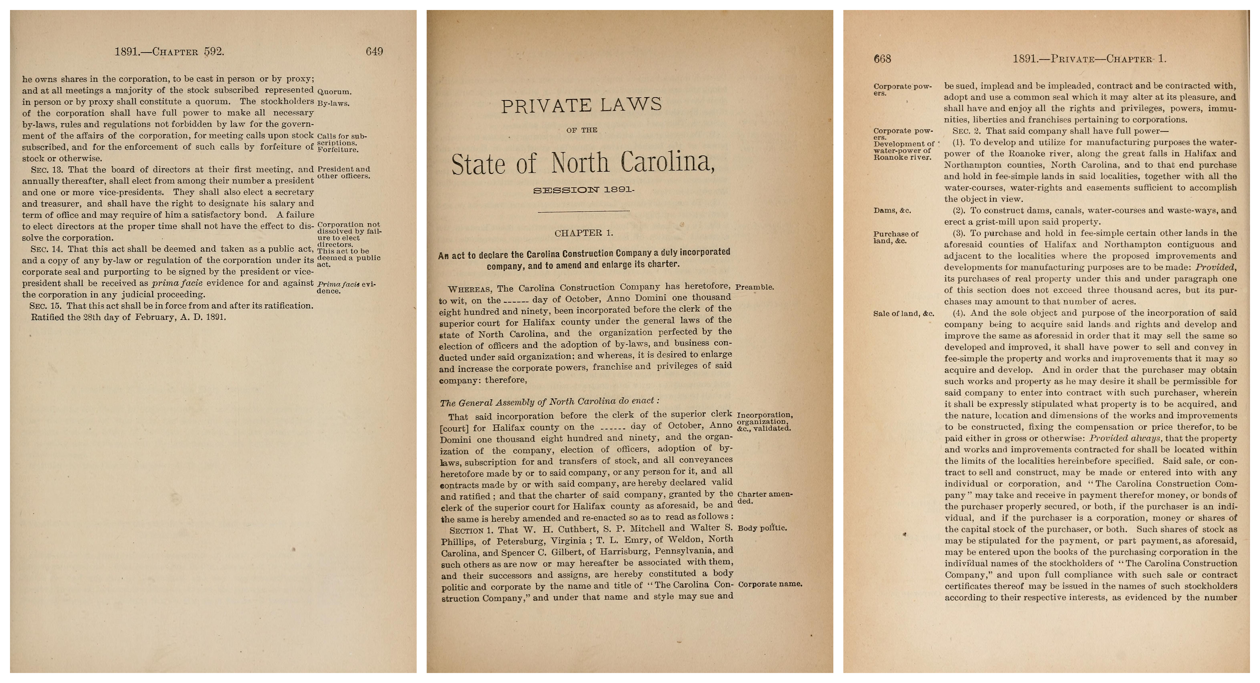

In [12]:
#hide_input
display(origdisplay(orig1, orig2, orig3))

Next, we set the page's "side" value. This represents the side of an open book on which one would find the page in question. This piece of metadata is important because it will indicate the side of the page on which we can expect to find marginalia.

In [13]:
side1 = master[0]["side"]

In [14]:
#remove
# repeat for demo purposes
side2 = master[1]["side"]
side3 = master[2]["side"]

### De-skewing

The text in scanned document pages will usually appear slightly rotated from the horizontal (see `orig2` above). In order to produce the best OCR results for our pages, we'll need to rotate each image and "straighten" our lines of text. To do so we use the `rotation_angle` function from cropfunctions.py. This function determines the original image's angle of rotation from the horizontal, which will be used later to "de-skew" our image.

The `rotation_angle` function accepts an original image variable as an argument. The image is then converted to a binarized numpy pixel array (`bin_img`). The function then defines a list of angles from -1 to 1 in intervals of .25 degrees. The loop iterates through this list, sending each angle along with `bin_img` to another crop function, `find_score`.

`find_score` evaluates rotations of `bin_img` according to each of the angles in the above list. It does so first by rotating the pixel array by the given angle. The rotated array (`data`) is then converted to a vertical histogram of pixel 'counts'. These values represent the number of non-zero pixels found along the horizontal axis for a given vertical axis coordinate. The function then calculates `score`, which is maximized for histograms with the most definitive 'peaks' and 'valleys'. A histogram with the most notable 'peaks' and 'valleys' is indicative of a text image with lines that run parallel to the horizontal axis. Thus, rotation angles that achieve higher scores have achieved more success in 'straightening' the original image. 

The after finding scores for each angle in the list, `rotation_angle` returns the angle with the highest score - the angle that will best straighten an image given its particular degree of skew.

*Note - the de-skewing operation was derived from this [guide](https://avilpage.com/2016/11/detect-correct-skew-images-python.html).*


In [15]:
ang1 = rotation_angle(orig1)

#Demo: Our first example image did not require any de-skewing.
print(ang1)

0.0


In [16]:
#remove
#repeat for demo purposes
ang2 = rotation_angle(orig2)
print(ang2)
ang3 = rotation_angle(orig3)
print(ang3)

-0.75
0.0


### Cropping to text and binarizing for color

Once we have determined an appropriate "de-skew" angle for the page, we determine the image's neutral background color, convert the image to a binary color scheme, and crop the image to the text itself. These steps are accomplished using the `trim` function from cropfunctions.py, which returns the following values:
* **diff**: PIL.Image.Image - Original image, with background color removed, cropped to area containing text (minus the header for most pages)
* **background**: tuple - Derived median background color, in same mode as original image
* **orig_bbox**: tuple - Coordinates of text crop (left,upper,right,lower) on the original image

The "find_top" parameter for the `trim` instructs the function to crop away the header section of each page if "TRUE" (which is the default value). This retains only the body text and accompanying marginalia for most pages. However, for section start pages, the large section headers contain useful metadata. For these pages we set the find_top parameter to "FALSE" so the trim function will return a cropped image that retains this important information.

Below is a detailed walkthrough of the `trim` process for one of our example images.

In [17]:
#example arguments
img=orig1
angle=ang1
buff=10
find_top=True

# Set the width and the height according to the image's dimensions.
width, height = img.size

# Establish the median pixel value for your image.
background = tuple(ImageStat.Stat(img).median)

# Create a new image with the same size/mode as the original. 
# Color the image according to the "background" value above.
bg = Image.new(mode = img.mode, size = img.size, color = background)

# This PIL function returns the absolute value of the pixel-by-pixel 
# difference between two images. The effect here is to generate 
# a high-contrast, "negative" version of the original image
diff = ImageChops.difference(img, bg)

# This step creates a binarized version of diff. The background color 
# is set to black (0), while the text appears white (1). This step 
# enables easier determination of text/non-text areas for later steps
# in the marginalia determination process.

# In order to binarize our image, we first determine an "offset" value
# for the step below. This value corresponds to 3 times the std. 
# deviation of the RGB color channel with the greatest amount of 
# variation for the image in question. 3 was chosen here as an 
# arbitrary value that works with our set of images. This value
# may require adjustment for use with other collections.
offset = round(max(ImageStat.Stat(diff).stddev) * 3)

# This effectively "brightens" all of the text values so 
# that they can be more easily distinguished from background "noise" 
# pixel values during the binary conversion process. 
# The "convert" function creates a new image with binary pixel values
# and very little "noise."
diff = ImageChops.add(diff, diff, 2.0, - offset).convert("1")

# rotate the image
if angle !=0:
    diff = diff.rotate(angle)

# calculate the bounding box of the 
# non-zero (i.e. text) areas of the image
bbox = diff.getbbox()

# If our page is a "start section" page, this step can be skipped.
# The above step will give us a bbox that encompasses all text 
# areas of the page, including the main body, the header, 
# and any marginalia. However, if the page is not a "section start"
# page, we remove the header, the top margin, and the bottom 
# margin from diff.
imglist=[]
if find_top:
    top = 0
    # The effect of this is to iterate through increasingly 
    # lower bands of diff starting with the top of the header. 
    # Once the .getbbox() function stops finding new non-zero values 
    # below a certain point within each new, deeper band,
    # we can interpret that point (top) as the bottom boundary 
    # of the header text. It is called "top" because it designates 
    # the top of the non-header area of the page.
    for k in range(50,361,30):
        
        try:
            imglist.append(diff.crop(bbox).crop((round(width/5),0,round(4*width/5),k)))
            h = diff.crop(bbox).crop((round(width/5),0,round(4*width/5),k)).getbbox()[3]
            if top == h and h >= 20:
                #check h>=20 to avoid small watermarks, characters are
                #usually taller than 20 pixels
                break
            elif h != k:
                top = h
        except:
            pass
        
    # Convert the bbox tuple to a list
    # so that it can be more easily edited
    bbox = list(bbox)
    
    # set bbox's upper boundary to "top", 
    # which is the bottom of the header.
    # Add buffer to make sure no header pixels are included
    bbox[1] += top+buff
    
    # Determine the text-containing areas of the new bbox, 
    # from which we just removed the header
    bbox1 = diff.crop(tuple(bbox)).getbbox()

    # "combine_bbox" maps changes made to a cropped version
    # of an image back onto the original version of 
    # that image. Here, the effect is to translate the cuts we've 
    # made to diff (removing the header), into a bbox that contains
    # only main text area of the original image (orig1)
    bbox = combine_bbox(bbox,bbox1)
    
# add a buffer (pre-set) on all sides of bbox, 
# ensuring that no body text areas have been left out.
bbox = buffer_bbox(bbox = bbox, buff = buff, width = width, height = height)


# This conditional statement accounts for situations in 
# which the "offset" value determined during the 
# binarization process is so high that all pixels in the image
# are reduced to black (0). If this is the case, no bbox can be found.
# Because offset is determined using the std. deviation of 
# image pixel values, such a situation occurs rarely, if ever.
if bbox:
    print(diff.crop(bbox), background, bbox)
else:
    print("None")

<PIL.Image.Image image mode=1 size=1815x1254 at 0x17A0F6E8D88> (214, 197, 169) (52, 316, 1867, 1570)


Now we perform the above steps using our example images.

In [18]:
if master[0]["start_section"]:
    diff1, background1, orig_bbox1 = trim(orig1, angle=ang1, find_top=False)
else:
    diff1, background1, orig_bbox1 = trim(orig1, angle=ang1)

In [19]:
#remove
#repeat for demo purposes
if master[1]["start_section"]:
    diff2, background2, orig_bbox2 = trim(orig2, angle=ang2, find_top=False)
else:
    diff2, background2, orig_bbox2 = trim(orig2, angle=ang2)

if master[2]["start_section"]:
    diff3, background3, orig_bbox3 = trim(orig3, angle=ang3, find_top=False)
else:
    diff3, background3, orig_bbox3 = trim(orig3, angle=ang3)
    

Below are the `diff` images for each of our three example pages. The middle page has retained a large area of its bottom margin because of an imperfection on the page itself (see the black ink dot in the bottom right margin area of the second image above). This was mistaken as "text" by the .getbbox() in the above steps for this particular image. 

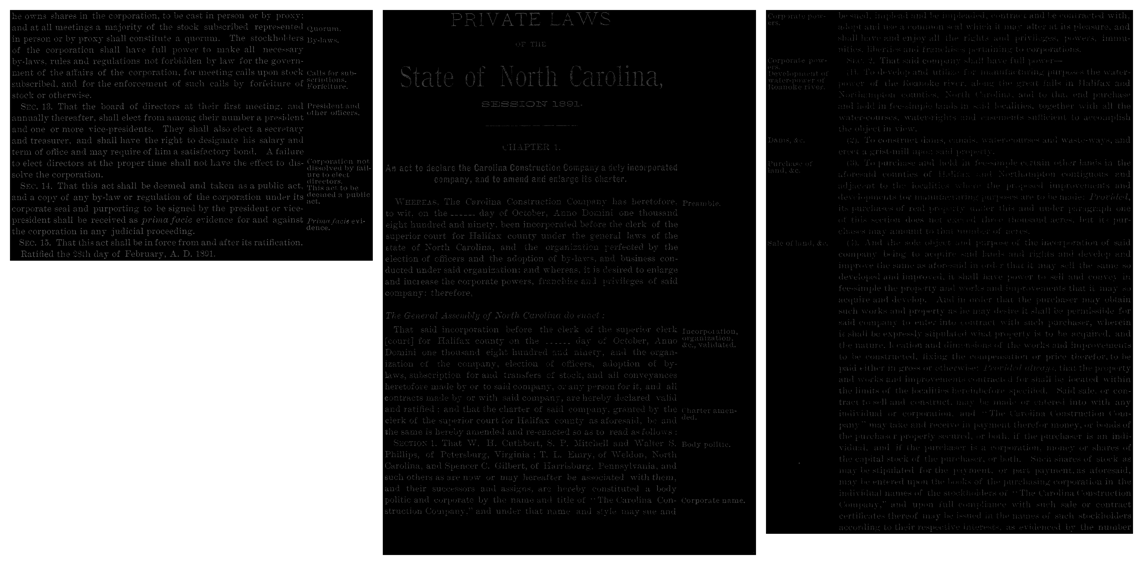

In [20]:
#hide input
# Demo: "diff" for each example image: 
# de-skewed, cropped to text with header-removed, color binarized
display(diffdisplay(diff1, diff2, diff3))

Once we have cropped the image only to include areas with text (without headers for most pages, with headers if the page is a "section start" page), the next step is to determine a dividing line to separate body text from marginalia. Once this line has been determined, we can produce a new set of coordinates that will crop all but the main body text from our original file.

*Note:
Starting in 1951, marginalia was eliminated from the print versions of laws. Image files from these decades do not need to undergo marginalia removal. The "orig_bbox" coordinates from the above section are adequate for determining the coordinates for the main body of text because there is no marginalia to eliminate. As a result, the production version of this module features the following code:*

In [21]:
if "196" in master[0]["folder"] or "195" in master[0]["folder"]:
    total_bbox1 = orig_bbox1
    cut1 = None

In [22]:
#remove
#repeat for demo purposes
if "196" in master[1]["folder"] or "195" in master[1]["folder"]:
    total_bbox2 = orig_bbox2
    cut2 = None

if "196" in master[2]["folder"] or "195" in master[2]["folder"]:
    total_bbox3 = orig_bbox3
    cut3 = None

### Finding the "cut" value to separate body from marginalia

#### get_bands

Despite the above caveat, most documents in our corpus will undergo the following cutting procedure. 

The first step is to split our `diff` image into horizontal bands. This is accomplished by the `get_bands` function from cropfunctions.py. In some ways, we are placing each page into a digital 'paper shredder' that will separate it into a number of horizontal strips. 

The `get_bands` function splits `diff` into horizontal bands with heights (in pixels) of `bheight`. In our case, `bheight` is set to 50 because that is the approximate height of a line of text. The function iterates top to bottom through all bands. Within each 50-pixel-high band of `diff`, a smaller boundary box is determined to encompass only those areas of the band that contain non-zero pixel values (i.e. text). The third parameter in this function, which is not called below but defaults to 20, is called `rd` (for "round"). 

The function returns a dictionary that contains:
1. A list of dictionaries (`band_bboxes`), one for each band. Each band dictionary contains values for `index`, `raw`, and `round`.
2. An integer for the `rd` value used by the function.

The keys in "band_bboxes" correspond to the following information:
* **"index":** The pixel coordinate of the bottom of the band. This allows one to situate the band within the larger image
* **"raw":** The raw bounding box for only the text-containing areas within that band
* **"round":** The raw bounding box rounded to the nearest `rd` pixels for the left and right coordinates

For most pages, many of the bands containing only main body text will be approximately the same width. Bands with indented text will be shorter, while bands with marginalia will be longer. We determine "rounded" versions of each band_bbox to reduce that amount of variation amongst the outer edge values of all bands. This will be important in determining the "cut" line between marginalia and main-body text.

In [23]:
bheight = 50
band_dict1 = get_bands(diff1, bheight=bheight)

In [24]:
#remove
#repeat for demo purposes
band_dict2 = get_bands(diff2, bheight=bheight)
band_dict3 = get_bands(diff3, bheight=bheight)

The example images below demonstrate the "banding" process. It is important to note that the images below show the bands superimposed on the original images rather than their `diff` versions. In reality, `get_bands` works with `diff` and not with `orig`.

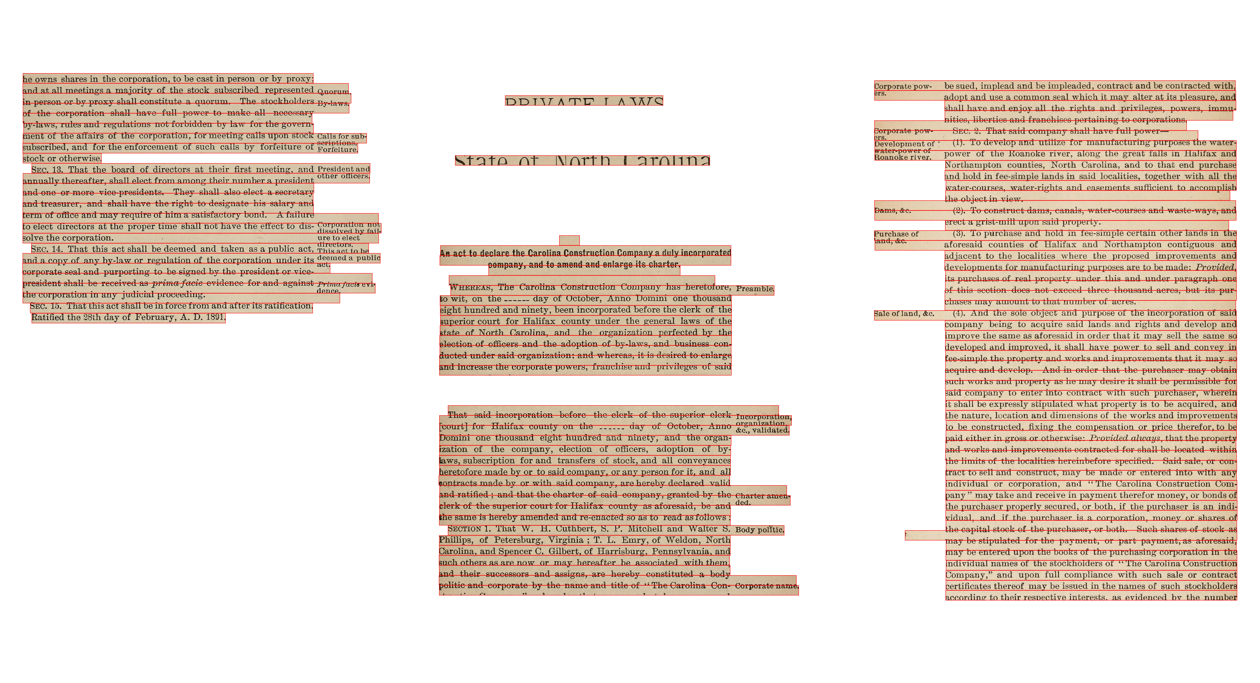

In [25]:
#hide input
bandimages = [bandimage(orig1, ang1, band_dict1, bheight, orig_bbox1),
             bandimage(orig2, ang2, band_dict2, bheight, orig_bbox2),
             bandimage(orig3, ang3, band_dict3, bheight, orig_bbox3)]
display(bandsdisplay(bandimages))

#### simp_bd

Once we have "banded" our image, we can determine the line that separates the marginalia from the main body text. This is accomplished using the `simp_bd` function from cropfunctions.py. This function looks at the outer edge of all bands to determine an appropriate horizontal coordinate pixel value to act as a "cut" line.


This function accepts as arguments `band_dict` from the previous step, the binarized, cropped version of the original image (`diff`), the `side` value, the `width` value (derived from `diff`), `pad`, and `frequency`. The `pad` argument increases or reduces the cut location to account for aggressively skewed images, while the `frequency` argument sets a threshold at which the cut coordinate is automatically determined because more than this proportion of outer band edges shared the same value.

In a basic sense, the operation of `simp_bd` consists of:
1. Filtering rounded band bboxes down to only their outer (L or R) edge coordinates
2. Winnowing down that list of coordinates to eliminate one-off values and values that fall outside the normal range of marginalia/body dividing lines. This gives us our list of "candidate" cut values
3. Choose either:
    1. The candidate coordinate that constitutes more than 80% of all candidates
    2. The best candidate from a variety of candidates, chosen according to the cut that produces the maximum difference in pixel density between the resulting "margin" and "text" bboxes. This is based off the assumption that marginalia bboxes will be more sparsely populated with text than main text bboxes.
4. If there are no candidate values within the allowable range, or the above algorithm results in an error, the 'cut' value is set to the outer edge of the page (0 for left, "width" for right).

The value returned by `simp_bd` is used to determine the outer edge of the bbox containing only the main body text with no marginalia.

Below is a detailed walkthrough of simp_bd for our third example image:

In [26]:
#Set example arguments
band_dict = band_dict1
diff = diff1
side = side1
width = diff1.size[0]
pad = 10
allow = (0.1, 0.3)
freq = 0.8
minfreq = 0.1

# create a list of the rounded band bboxes
bands = [v["round"] for v in band_dict["band_bboxes"]]

# create a list of the raw band bboxes
raw = [v["raw"] for v in band_dict["band_bboxes"]]

# get the round ("rd") value from the band_dict in question. 
rd_dist = band_dict["rd"]

# This assigns integer values to each string value of "side"
# This is important because it tells the function
# which edge in the band bboxes to consider as the "outer" edge
# the side that will be adjacent to any marginalia. 
# Bboxes indicate L, T, R, B, so left (L) is set to 0, 
# while right (R) is set to 2
side_dict = {"left":0, "right":2}

# strip_list returns a filtered list of all L/R values 
# depending on the side you send it
# This list has been filtered for any one-off values
# to avoid bad cut candidates
bands = strip_list(bands, side_dict[side])

# Set minimum and maximum allowable pixel values based on the
# side & width of the page.This is done by determining the range
# of pixel values for a given page that is between a distance of
# .1 and .3 times (see "allow" variable) the total width of the page
# from the outside edge of the page. These values are set because 
# most lines that divide main body from marginalia will appear in
# this area of a given page. As a result, bands with L or R edges
# that are unusually close to or far from the outside of edge of 
# a page are eliminated as candidates for cutting
try:  
    if side == "right":
        pixmin = width-allow[1] * width
        pixmax = width-allow[0] * width
        newbands = [b for b in bands if b > pixmin and b < pixmax]
        rev = True
    elif side == "left":
        pixmin = allow[0] * width
        pixmax = allow[1] * width
        newbands = [b for b in bands if b > pixmin and b < pixmax]
        rev = False

# Once we have determined the list of viable cut candidates within 
# our allowable range of outer band edges (newbands), we check 
# to see if that list contains any values. If it doesn't, and we were 
# unable to find any bands that had edges within our allowable range, 
# we set our cut value to the outside edge of the original cropped image
# (0 for Left, width for Right). However, if newbands
# is NOT empty, we perform the following operation:
    if newbands:
        
        # get counts for all of the candidate edge values
        # the reverse parameter sorts values according to
        # how close they are to a page's side:
        # low-high for left, high-low for right
        ct = Counter(sorted(newbands, reverse=rev))

        # determine which allowable edge value is most frequent
        # If that value represents more than `freq` of all values
        # in newbands (i.e. allowable values), set cut to that value.
        # If "cut" combined with "pad" (see above) is within 
        # the total bounds of  our original cropped image (diff),
        # then we take that value as our final "cut" value
        if ct.most_common(1)[0][1]/(sum([e for e in dict(ct).values()])) > freq:
            cut = [e[0] for e in ct.most_common(1)][0]
            if side == "right":
                cut = min(cut + pad, width)
            elif side == "left":
                cut = max(cut - pad, 0)
        
        # If none of the viable cut candidates show a clear majority, 
        # we choose the best candidate: this loop first filters our 
        # set of edge candidates down to those which appear more often than 
        # our minimum frequency value (minfreq). 
        
        # Once this smaller subset has been determined, we iterate through 
        # each remaining candidate and create a sample "cut". 
        # For each "cut", we determine the pixel density for
        # the resulting marginalia bbox ("margin_bbox") and main
        # text bbox ("text_bbox"). The "best" candidate is that which
        # maximizes the difference between these two values.
        else:
            m = [k for k in ct.keys() if ct[k] > len(newbands)*minfreq]
            cut_dict = {k:0 for k in m}
            if len(m)>1:
                for cut in m:
                    text_bbox = [0, 0] + list(diff.size)
                    text_bbox[side_dict[side]] = cut
                    other = abs(side_dict[side]-2)
                    text_bbox[other] = (1-side_dict[side]) * (50)+cut
                    margin_bbox = [0, 0] + list(diff.size)
                    margin_bbox[side_dict[side]] = (side_dict[side]-1) * (50)+cut
                    margin_bbox[other] = cut
                    mean_diff = np.mean(diff.crop(text_bbox)) - np.mean(diff.crop(margin_bbox))
                    cut_dict[cut] += mean_diff
                cutrange = max(cut_dict, key=cut_dict.get)
            elif len(m)==1:
                cutrange = m[0]
                
            # Generate a list of candidate cuts that fall
            # within an acceptable "cutrange"
            pix_list = [i[side_dict[side]] for i in raw if abs(i[side_dict[side]]-cutrange) < rd_dist/2]


            # If the page is a "right" page, select the remaining
            # candidate that is furthest to the right. If that 
            # cut is outside the original page width, 
            # set the cut to equal to the image width
            if side == "right":
                cut = min(max(pix_list)+pad, width)

            # If the page is a "left" page, select the remaining
            # candidate that is furthest to the left.
            # If that cut is less than zero, set the cut to equal
            # to zero to avoid cutting outside of the page boundaries.
            elif side == "left":
                cut = max(min(pix_list)-pad, 0)
    else:
        #If no cut was determined, set cut equal to the edge of the page.
        if side == "right":
            cut = width
        elif side == "left":
            cut = 0

# Print statements used here instead 
# of return statements for demonstration purposes.

    print("return cut:", cut)

except:
    if side == "left":
        print("return 0:", 0)
    elif side == "right":
        print("return width:", width)

return cut: 1470


In [27]:
width1 = diff1.size[0]
cut1 = simp_bd(band_dict=band_dict1, diff=diff1, side=side1, width=width1,
              pad=10, freq =0.9)

In [28]:
#remove
width2 = diff2.size[0]
cut2 = simp_bd(band_dict=band_dict2, diff=diff2, side=side2, width=width2,
              pad=10, freq =0.9)
width3 = diff3.size[0]
cut3 = simp_bd(band_dict=band_dict3, diff=diff3, side=side3, width=width3,
              pad=10, freq =0.9)

### Applying cuts to original images

Recall that our "banding" and "cutting" procedures have used `diff`, the *cropped and binarized version* of our original image. The following pieces of code allow us to determine the main-body-text bbox from `orig`, the *original version* of our image. The information describing this new bbox is the metadata that we will eventually store so that later modules can work directly with the original image files.

To begin this next step, we first determine the main-body-text-bbox from `diff`:

In [29]:
# create a bbox for the entire diff image
out_bbox1 = [0, 0] + list(diff1.size)
# Set the side value so that the function 
# knows which bbox dimension to "cut"
side_dict = {"left":0, "right":2}
# Set the outer edge of the page equal to cut, 
# rather than the original outer edge from diff
# This creates a bbox that is cropped to include 
# only the main text areas of diff
out_bbox1[side_dict[side1]] = cut1

In [30]:
#remove
out_bbox2 = [0, 0] + list(diff2.size)
out_bbox2[side_dict[side2]] = cut2
out_bbox3 = [0, 0] + list(diff3.size)
out_bbox3[side_dict[side3]] = cut3

Next, we use `combine_bbox` from cropfunctions.py to determine the main body bbox for the original image, `orig`. Recall here that `orig_bbox` contains the crop dimensions for `diff` from within the original image file. 

The function uses `orig_bbox` to situate `diff` within the original image. It then adjusts the values from `orig_bbox` to accommodate for the differences between `diff` and its "cut" version, represented by `out_bbox`.

In other words, earlier we used our cropped version of the original image to determine the "cut" line separating main body text from marginalia. As a result, we find the location of that cropped version within the original image (`orig_bbox`) and adjust it based on our "cut" values (`out_bbox`). The resulting bbox (`total_bbox`) encompasses only the main-body text area of the *original image*

In [31]:
total_bbox1 = combine_bbox(orig_bbox1,out_bbox1)

In [32]:
#remove
total_bbox2 = combine_bbox(orig_bbox2,out_bbox2)
total_bbox3 = combine_bbox(orig_bbox3,out_bbox3)

The image below shows each of our original page images, cropped to include only the main body text with no marginalia. The middle page retains its header information because it is a "section_start" page. 

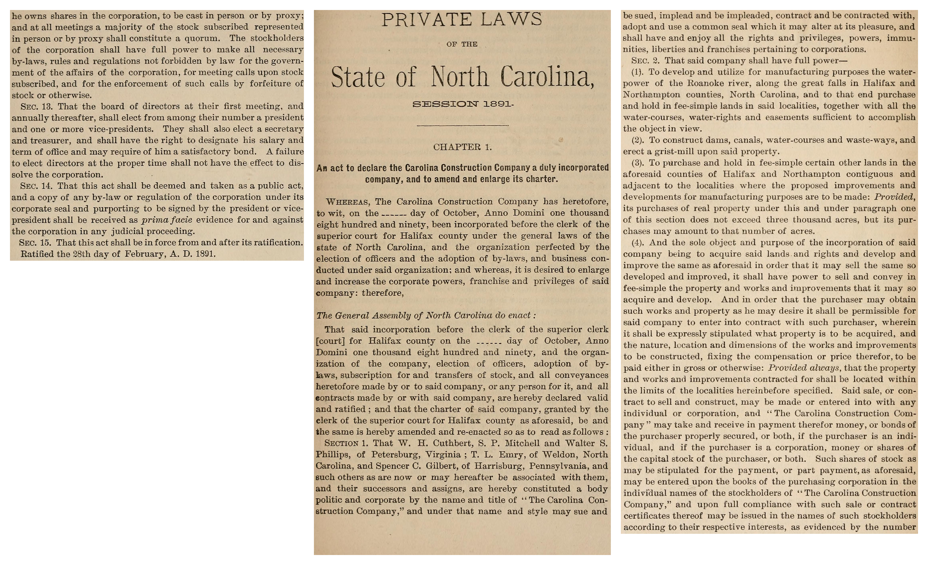

In [33]:
#hide input

finalimages = [orig1.rotate(ang1).crop(total_bbox1),
               orig2.rotate(ang2).crop(total_bbox2),
               orig3.rotate(ang3).crop(total_bbox3)]
display(finalsdisplay(finalimages))


### Compiling metadata

After we've determined the angle, side, and cut values, we add them along with the associated image's filename, the RGB color values of the image's median background color (`background`), and the image's `total_bbox` dimensions to a list of metadata for each file. This list is then added to our overall `meta` list (see beginning of the "Gathering unedited image files" section). In the production code that loops through all images in a batch, `meta` will contain metadata for all images in each batch.

In [34]:
meta_list1 = [master[0]["filename"], ang1, side1, cut1]
meta_list1.extend(background1)
meta_list1.extend(total_bbox1)
meta.append(meta_list1)

In [35]:
#remove
meta_list2 = [master[0]["filename"], ang2, side2, cut2]
meta_list2.extend(background2)
meta_list2.extend(total_bbox2)
meta.append(meta_list2)

meta_list3 = [master[0]["filename"], ang3, side3, cut3]
meta_list3.extend(background3)
meta_list3.extend(total_bbox3)
meta.append(meta_list3)

We then output the compiled metadata for all of our images to a .csv file.

In [36]:
headers = ["file","angle","side","cut","backR","backG","backB",
           "bbox1","bbox2","bbox3","bbox4"]
with open("output\marginalia_metadata_demo.csv","a",newline="") as outfile:
    writer=csv.writer(outfile)
    writer.writerow(headers)
    for row in meta:
        writer.writerow(row)

The output file contains the following fields:

In [37]:
#hide_input
df = pd.read_csv("output\marginalia_metadata_demo.csv")
df.head()

file  angle   side   cut  backR  backG  backB  \
0  lawsresolutionso1891nort_0697.jp2   0.00  right  1470    214    197    169   
1  lawsresolutionso1891nort_0697.jp2  -0.75  right  1485    206    185    154   
2  lawsresolutionso1891nort_0697.jp2   0.00   left   350    225    205    176   

   bbox1  bbox2  bbox3  bbox4  
0     52    316   1522   1570  
1     50    427   1535   3153  
2    494    352   1980   2972

The purpose of each field is as follows:
1. **file**: Used to indicate the page image associated with each row of metadata
2. **angle** & **bbox1** - **bbox4**: Used to crop the page image to OCR-ready sections
3. **side** & **cut**: Retained for checking purposes
4. **backR**, **backG**, & **backB**: The RGB values for the median background color. Used to create buffer areas around the cropped text to produce cleaner OCR output.

## Recap

To recap, marginalia_determination consists of the following steps. Associated functions from cropfunctions.py are listed next to each step:

1. Determine important metadata for a batch of images. This metadata comes from a combination of manually-generated information and metadata gathered from the Internet Archive and includes information like filepath, law type, page side, and whether or not a page begins a new section.
2. Import batch image files
3. Determine the best de-skew angle for straightening pages (`rotation_angle` and `find_score`).
4. Determine the image's median background color as well as a bounding box that has been cropped to text with headers removed where appropriate (`trim`).
5. Determine the dividing "cut" line between main body text and marginalia (`get_bands` and `simp_bd`).
6. Derive main-body text bounding coordinates for the original page image (`combine_bbox`).
7. Record results from the above steps in a new crop metadata file.

The left image below shows an original page image, `orig`, with `orig_bbox` outlined in red. On the right you can see `diff`, which results from both the de-skewing (`rotation_angle` and `find_score`) and `trim` processes. Essentially, `diff` is the `orig_bbox` area from `orig` after being de-skewed and binarized for color.

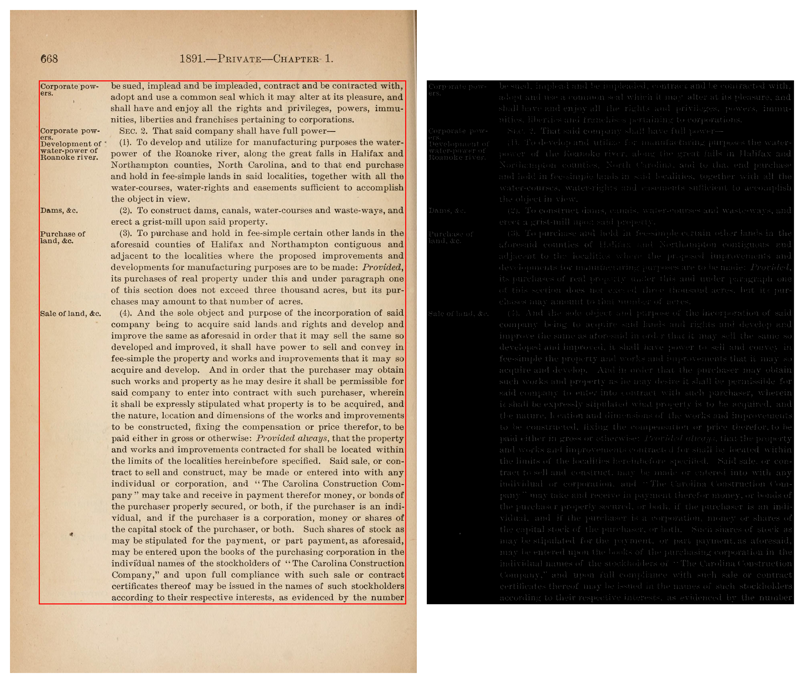

In [38]:
#hide_input
demo2 = comparison1(orig3, diff3, ang3, orig_bbox3)
display(demo2)

The left image below shows `diff` once again, this time with the bands from the `get_bands` outlined in orange. The `cut` line from `simp_bd` is outlined in blue. The right image shows the final crop, after the information stored in `out_bbox` has been converted to work with with `orig` via the `combine_bbox` function. This image represents `orig` cropped to the dimensions stored in `total_bbox`. After these operations, the final boundary box along with other metadata (see above) are stored in the output file.

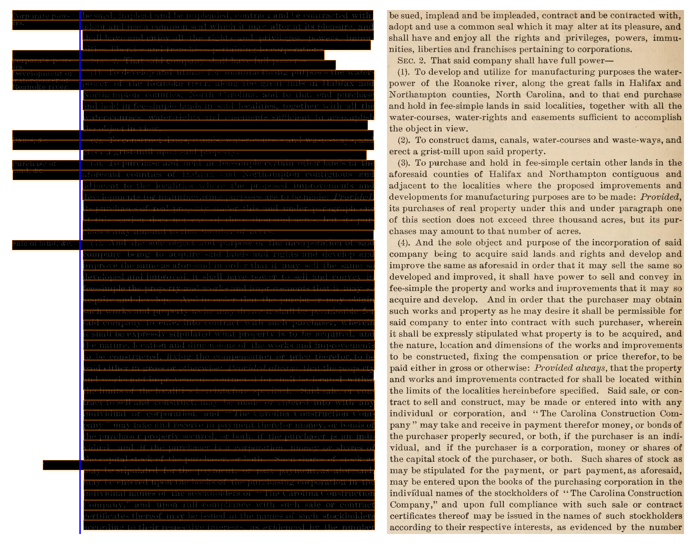

In [39]:
#hide_input
band = diffbands(diff3, band_dict3, cut3, bheight)
final = orig3.rotate(ang3).crop(total_bbox3)
demo3 = comparison2(band, final)
display(demo3)